# Online Learning Project
## [Paper] "A Tutorial on Conformal Prediction" by Glenn Shafer and Vladimir Vovk

In this paper, the authors present a novel method for evualuating how a machine learning model is accurate in the online setting. Given a desired confidence level $\epsilon$, the method constructs a confidence region for the predicted value that doesn't include the true value whith a probability at most $\epsilon$.

In this notebook we will implement the conformal prediction algorithm for both **classification** and **regression** and test it on some widely used datasets.

#### Some imports and global variables :

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
import pandas as pd
from scipy import stats
from sklearn.datasets import load_iris

import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

The only hypothesis we need to use conformal prediction is that the samples of the training data are exchangeable. In the particular case were the samples are assumed to be i.i.d, this is obviously verified.

## Conformal Algorithm using old examples alone

Let's generate some random i.i.d values :

In [311]:
n_samples = 20
n_trials = 5
samples = np.random.binomial(n=n_trials, p=1/3, size=n_samples)

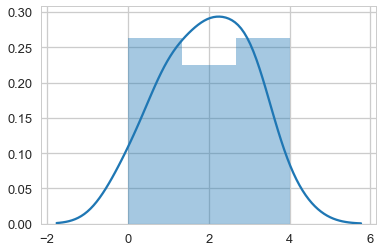

In [312]:
sns.distplot(samples)

In [313]:
def nonconformity_measure(previous_values, new_value):
    estimation = np.sum(previous_values) + new_value
    estimation /= (len(previous_values) + 1.)
    
    return np.abs(estimation - new_value)

def conformal_algorithm_from_old_examples(non_conformity_measure, previous_examples, new_example, epsilon):
    n = len(previous_examples) + 1
    examples = list(previous_examples) + [new_example]

    alphas = []
    for i in range(n):
        alphas.append(non_conformity_measure(examples[:i] + examples[i+1:], examples[i]))

    p = np.mean(np.array(alphas) >= alphas[-1])
    return p > epsilon

In [316]:
errors = []
avg_region_size = []
space = np.linspace(0.99, 0.01, 10)
for e in space:
    hits = []
    confidence_regions = []
    for i, value in enumerate(samples):
        confidence_region = []
        for outcome in range(n_trials):
            accept = conformal_algorithm(
                nonconformity_measure, samples[:i], outcome, epsilon=e
            )
            if accept:
                confidence_region.append(outcome)

        hits.append(value in confidence_region)
        confidence_regions.append(confidence_region)
    avg_region_size.append(np.mean([len(region) for region in confidence_regions]))
    errors.append(1  - np.mean(hits))

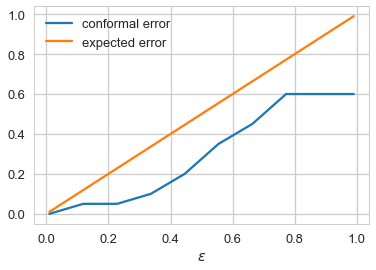

In [318]:
plt.plot(space, errors, label="conformal error")
plt.plot(space, space, label="expected error")
plt.xlabel('$\\epsilon$')
plt.legend()
plt.show()

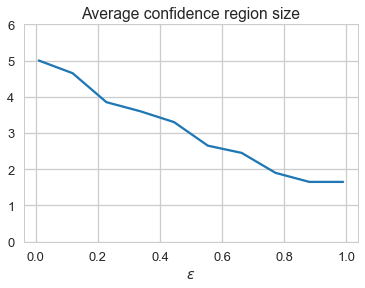

In [319]:
plt.title("Average confidence region size")
plt.ylim(0, 6)
plt.plot(space, avg_region_size)
plt.xlabel('$\\epsilon$')
plt.show()

## Conformal Algorithm using a new object

In [337]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [338]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [339]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [340]:
def nonconformity_measure(previous_X, previous_y, new_X, new_y):
    measure = np.linalg.norm(new_X - np.array(previous_X)[previous_y==new_y], ord=2, axis=1).min() / \
        np.linalg.norm(new_X - np.array(previous_X)[previous_y!=new_y], ord=2, axis=1).min()
    
    return measure

def conformal_algorithm_using_new_object(non_conformity_measure, previous_X, previous_y, new_X, new_y, epsilon):
    n = len(previous_X) + 1
    X = list(previous_X) + [new_X]
    y = list(previous_y) + [new_y]

    alphas = []
    for i in range(n):
        alphas.append(non_conformity_measure(
            X[:i] + X[i+1:], y[:i] + y[i+1:], X[i], y[i]
        ))

    p = np.mean(np.array(alphas) >= alphas[-1])
    return p > epsilon

In [341]:
errors = []
avg_region_size = []
space = np.linspace(0.99, 0.01, 10)
for e in tqdm(space):
    hits = []
    confidence_regions = []
    for i in range(len(X_test)):
        confidence_region = []
        for category in set(y_train):
            accept = conformal_algorithm_using_new_object(
                nonconformity_measure, X_train, y_train, X_test[i], category, epsilon=e
            )
            if accept:
                confidence_region.append(category)

        hits.append(model.predict(X_test[i:i+1]) in confidence_region)
        confidence_regions.append(confidence_region)
    avg_region_size.append(np.mean([len(region) for region in confidence_regions]))
    errors.append(1  - np.mean(hits))

100%|██████████| 10/10 [00:23<00:00,  2.35s/it]


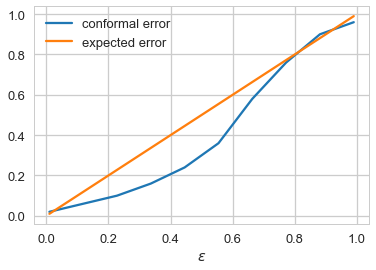

In [342]:
plt.plot(space, errors, label="conformal error")
plt.plot(space, space, label="expected error")
plt.xlabel('$\\epsilon$')
plt.legend()
plt.show()

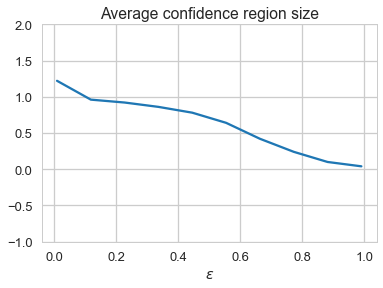

In [343]:
plt.title("Average confidence region size")
plt.ylim(-1, 2)
plt.plot(space, avg_region_size)
plt.xlabel('$\\epsilon$')
plt.show()